In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import tensorflow as tf
import sklearn

In [27]:
base = pd.read_csv('petr4_treinamento.csv')
base = base.dropna()
base_treinamento = base.iloc[:, 1:2].values
base_valor_maximo = base.iloc[:, 2:3].values

In [28]:
normalizador = MinMaxScaler(feature_range=(0, 1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)
base_valor_maximo_normalizada = normalizador.fit_transform(base_valor_maximo)

In [29]:
previsores = []
preco_real1 = []
preco_real2 = []
for i in range(90, 1242):
    previsores.append(base_treinamento_normalizada[i-90:i, 0])
    preco_real1.append(base_treinamento_normalizada[i, 0])
    preco_real2.append(base_valor_maximo_normalizada[i, 0])
previsores, preco_real1, preco_real2 = np.array(previsores), np.array(preco_real1), np.array(preco_real2)
previsores = np.reshape(previsores, (previsores.shape[0], previsores.shape[1], 1))

In [30]:
preco_real = np.column_stack((preco_real1, preco_real2))

In [31]:
regressor = Sequential()
regressor.add(InputLayer(shape=(previsores.shape[1], 1)))
regressor.add(LSTM(units=100, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=2, activation='linear'))

In [32]:
regressor.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mean_absolute_error'])
regressor.fit(previsores, preco_real, epochs=100, batch_size=32)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0718 - mean_absolute_error: 0.2038
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - loss: 0.0186 - mean_absolute_error: 0.1061
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.0134 - mean_absolute_error: 0.0902
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0120 - mean_absolute_error: 0.0844
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0112 - mean_absolute_error: 0.0810
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0104 - mean_absolute_error: 0.0787
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0091 - mean_absolute_error: 0.0730
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.0089 - mean_absolute_error: 0.0722
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 101ms/step - loss: 0.0083 - mean_absolute_error: 0.0691
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0084 - mean_absolute_error: 0.0699
Epoch 11/100
36/36 ━━━━━━━━

In [33]:
base_teste = pd.read_csv('petr4_teste.csv')
preco_real_open = base_teste.iloc[:, 1:2].values
preco_real_high = base_teste.iloc[:, 2:3].values

In [34]:
base_completa = pd.concat((base['Open'], base_teste['Open']), axis=0)
entradas = base_completa[len(base_completa) - len(base_teste) - 90:].values
entradas = entradas.reshape(-1, 1)
entradas = normalizador.transform(entradas)

In [35]:
X_teste = []
for i in range(90, 112):
    X_teste.append(entradas[i-90:i, 0])
X_teste = np.array(X_teste)
X_teste = np.reshape(X_teste, (X_teste.shape[0], X_teste.shape[1], 1))

In [36]:
previsoes = regressor.predict(X_teste)
previsoes = normalizador.inverse_transform(previsoes)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


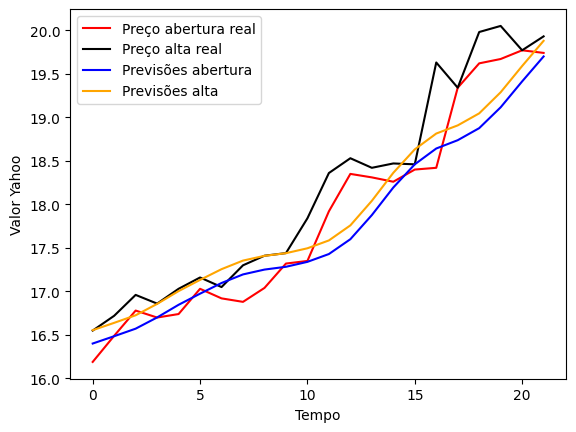

In [37]:
plt.plot(preco_real_open, color = 'red', label = 'Preço abertura real')
plt.plot(preco_real_high, color = 'black', label = 'Preço alta real')
plt.plot(previsoes[:, 0], color = 'blue', label = 'Previsões abertura')
plt.plot(previsoes[:, 1], color = 'orange', label = 'Previsões alta')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()
plt.show()